<a href="https://colab.research.google.com/github/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/blob/main/3%20Exploratory%20Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA Part 2**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install openpyxl -q
# import openpyxl
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# distance on the map
!pip install geopy -q
from geopy.distance import geodesic

# for Moran I
!pip install libpysal -q
import libpysal
!pip install esda -q
from esda.moran import Moran

# Set display options
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 1000)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
# apartments = pd.read_excel('https://raw.githubusercontent.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/main/apartments3.xlsx', engine='openpyxl')

In [2]:
# import pickle

!wget https://github.com/IlyaZutler/Project-3-Berlin-Airbnb-Ratings/raw/main/apartments3.pkl -q

with open('apartments3.pkl', 'rb') as f:
    apartments = pickle.load(f)

## Spatial Autocorrelation of Location Rating and Price


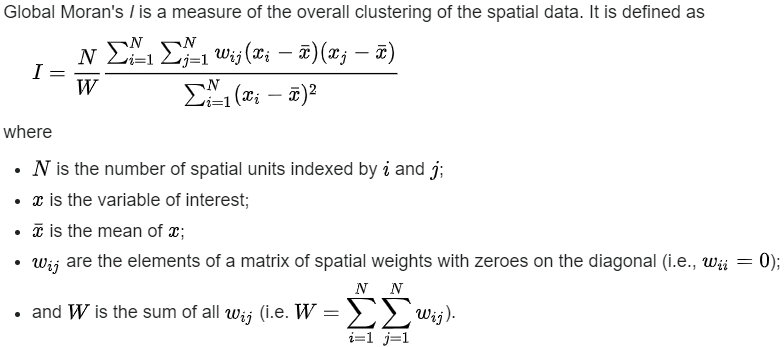

### Dividing the city into a grid
A rough calculation on the plain requires N^2 operations.

Therefore, to reduce the computational complexity, we will divide the city into a grid.

In [3]:
# !pip install geopy -q
# from geopy.distance import geodesic

coords_e = (apartments['Latitude'].max() , apartments['Longitude'].min())
coords_w = (apartments['Latitude'].max() , apartments['Longitude'].max())
distance_meters = geodesic(coords_e, coords_w).kilometers

distance_str = "{:,.2f}".format(distance_meters).replace(",", " ")
print(f"Distance from East to West  : {distance_str} km")

coords_s = (apartments['Latitude'].min() , apartments['Longitude'].max())
coords_n = (apartments['Latitude'].max() , apartments['Longitude'].max())
distance_meters = geodesic(coords_s, coords_n).kilometers

distance_str = "{:,.2f}".format(distance_meters).replace(",", " ")
print(f"Distance from North to South : {distance_str} km")


Distance from East to West  : 44.70 km
Distance from North to South : 34.04 km


We divide the city into squares of 250x250 meters


For small distances, the angular grid (Latitude-Longitude) can be considered as rectangular (if we are far from the poles)

In [4]:
# devide Latitude and Longitude
# 44.7 / 0.25 = 179,  34/0.25 = 136
lat_bin = np.linspace(apartments['Latitude'].min(), apartments['Latitude'].max(), 180)  #179 bins 180 points
lon_bin = np.linspace(apartments['Longitude'].min(), apartments['Longitude'].max(), 137)  # 136 bins 137 points

# make Latitude_No and Longitude_No
apartments['Latitude_Bin'] = pd.cut(apartments['Latitude'], bins=lat_bin, labels=False, include_lowest=True)
apartments['Longitude_Bin'] = pd.cut(apartments['Longitude'], bins=lon_bin, labels=False, include_lowest=True)

# find Latitude_No and Longitude_No
def determine_bins(lat, lon, lat_bin, lon_bin):
    lat_bin = np.digitize(lat, lat_bin) - 1
    lon_bin = np.digitize(lon, lon_bin) - 1
    return lat_bin, lon_bin

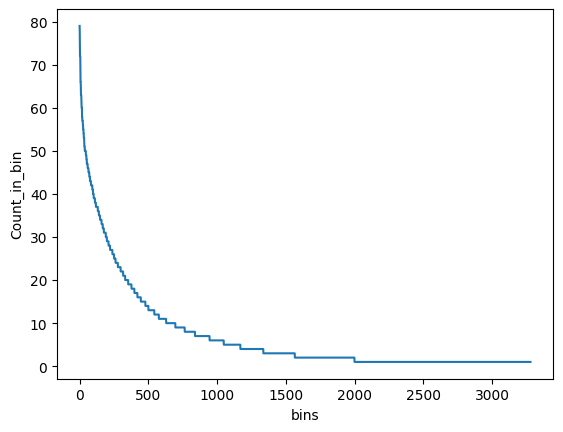

In [ ]:
# how many apartments in bins
unique_counts = apartments[['Latitude_Bin', 'Longitude_Bin']].value_counts().reset_index()
unique_counts.columns = ['Latitude_Bin', 'Longitude_Bin', 'Count_in_bin']
sns.lineplot(data=unique_counts, x=unique_counts.index, y='Count_in_bin')
plt.xlabel('bins')
plt.show()

### Rating and Price autocorrelation
(required 20 minutes to calculated)

In [ ]:
# !pip install geopy -q
# from geopy.distance import geodesic
# import libpysal
# from esda.moran import Moran

def create_inverse_distance_weight_matrix(df, weight_col ='Reviews', threshold_km = 0.2, epsilon = 0.03, bin_range = 1):

    weights_dict = {i: {} for i in range(len(df))}

    for i in range(len(df)):
        lat_i, lon_i = df.loc[i, 'Latitude'], df.loc[i, 'Longitude']
        lat_bin_i, lon_bin_i = df.loc[i, 'Latitude_Bin'], df.loc[i, 'Longitude_Bin']

        nearby_bins = df[(df['Latitude_Bin'] >= lat_bin_i - bin_range) & (df['Latitude_Bin'] <= lat_bin_i + bin_range) &
                        (df['Longitude_Bin'] >= lon_bin_i - bin_range) & (df['Longitude_Bin'] <= lon_bin_i + bin_range)]

        has_neighbors = False
        for j in range(len(nearby_bins)):
            if nearby_bins.index[j] != i:
                lat_j, lon_j = nearby_bins.iloc[j]['Latitude'], nearby_bins.iloc[j]['Longitude']
                dist_km = geodesic((lat_i, lon_i), (lat_j, lon_j)).kilometers
                if dist_km <= threshold_km:
                    weight = 1 / (dist_km + epsilon) * df.loc[i, weight_col] * nearby_bins.iloc[j][weight_col]
                    weights_dict[i][nearby_bins.index[j]] = weight
                    has_neighbors = True

        # Если у точки нет соседей, добавляем саму точку как собственного соседа с весом 0
        if not has_neighbors:
            weights_dict[i][i] = 0

    # transform to format for libpysal
    w = libpysal.weights.W(weights_dict)
    return w

df_r = apartments[['Latitude', 'Longitude', 'Latitude_Bin', 'Longitude_Bin','Location Rating','Reviews']]
df_r['Reviews'] = np.log1p(df_r['Reviews'])

df_r.dropna(inplace=True)
df_r = df_r.reset_index(drop=True)
w = create_inverse_distance_weight_matrix(df_r)

# Moran's I
moran = Moran(df_r['Location Rating'].values, w)
print(f"Local Rating Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")


Local Rating Moran's I: 0.2227789199060552
p-value: 0.001


In [ ]:
df_p = apartments[['Latitude', 'Longitude', 'Latitude_Bin', 'Longitude_Bin','Price','Reviews']]
df_p['Reviews'] = np.log1p(df_p['Reviews'])
df_p.dropna(inplace=True)
df_p = df_p.reset_index(drop=True)
w = create_inverse_distance_weight_matrix(df_p)

# Moran's I
moran = Moran(df_p['Price'].values, w)
print(f"Price Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

Price Moran's I: 0.23044010886589986
p-value: 0.001


In [ ]:
# apartments.to_excel('apartments_4.xlsx', index=False)

In [ ]:
import pickle

# save lat_bin, lon_bin
with open('lat_bin.pkl', 'wb') as f:
    pickle.dump(lat_bin, f)
with open('lon_bin.pkl', 'wb') as f:
    pickle.dump(lon_bin, f)


In [5]:
# import pickle

with open('apartments4.pkl', 'wb') as f:
    pickle.dump(apartments, f)

-------------------end of 3-----------------------